In [ ]:
%matplotlib inline

In [ ]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

# Part 1: Overfitting 

The goal of this example is to better understand generalization in linear regression example. The target function that we want to fit is: 
\begin{align*}
f(x) = \sin(2\pi x) \enspace .
\end{align*}

In [ ]:
def f(x):
  return jnp.sin(2*jnp.pi*x)


We then sample 100 independent datasets by sampling the domain of $f$ within $[0, 1]$ uniformly at random.

In [ ]:
key = jax.random.PRNGKey(6650)

In [ ]:
n_samples = 25
n_datasets = 100

X = jax.random.uniform(key, shape=(n_datasets, n_samples))
key, subkey = jax.random.split(key)
noises = jax.random.normal(key, shape=(n_datasets, n_samples))*5e-1
Y = f(X) + noises

We are going to fit this function by linear regression over a Gaussian basis function. That is, we want to express our model as: 
\begin{align*}
f(x; \theta) = \theta^\top \phi(x) \enspace ,
\end{align*}
where $\phi: \mathbb{R}^n \to \mathbb{R}^k$ is the feature mapping. In this exercise, we use Gaussian basis functions of the form: 
\begin{align*}
[\phi(x)]_i = \exp\left(-\frac{(x - \mu_i)^2}{2\sigma_i^2}\right) \enspace.
\end{align*}

The location $\mu_i$ and scale $\sigma_i$ are hyperparameters. In the following, we fix the standard deviation to some chosen value and scatter the basis functions uniformly on the grid.


In [ ]:
def gaussian_basis_function(location, scale):
  def phi(x):
    return jnp.exp(-(x-location)**2/(2*scale**2))
  return phi

In this exercise, we find the parameters of our linear predictor using the closed-form solution for the ridge regression problem. Implement the code to compute the ridge regression solution using the SVD decomposition. **There shouldn't be any explicit matrix inversion in your solution**.

In [ ]:
from numpy.core.fromnumeric import transpose
def ridge_regression(X, y, phi, lmbda=0.):
  """
  X (ndarray): Design matrix (n_samples,)
  y (ndarray): y targets (n_samples,)
  lmbda (float): regularization coefficient
  """
  # Featurize
  
  A = jax.vmap(phi)(X)
  print(f'X:{X.shape}, A:{A.shape}')

  # SVD decomposition
  U, D, V = jnp.linalg.svd(A)

  # Create rectangular version of D
  diag_D = jnp.diag(D) 
  padding = jnp.zeros((U.shape[1]-D.shape[0], D.shape[0]))
  padded_D = jnp.concatenate((diag_D, padding))

  print(f"U: {U.shape}, D: {padded_D.shape}, V: {V.shape}")

  # Compute pseudo inverse
  par = D**2 + lmbda
  reciprocal = 1/par
  diag_reciprocal = jnp.diag(reciprocal) 
  inverse = diag_reciprocal.T

  return V.dot(inverse).dot(padded_D.T).dot(U.T).dot(y)


We can now apply our code to solve for all of the ridge regression problems simultaneously using the powerful [vmap](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#auto-vectorization-with-vmap) function in JAX. First, we instantiate our feature mapping $\phi$ by scattering the Gaussian RBFs uniformly on the grid:

In [ ]:
scale = 0.1
n_basis = 4
scales = jnp.ones(shape=(n_basis,))*scale
locations = jnp.linspace(0,1,n_basis)

phi = gaussian_basis_function(locations, scales)


Using `vmap` we can transform $\phi$ such that it can be applied across a dataset using only one call. For example:



In [ ]:
jax.vmap(phi)(X[0,:]).shape

(25, 4)

Since we want to compute the ridge regression solutions over all datasets, we can apply vmap one more time at this level: vmapped functions can also be vmaped over:

In [ ]:
ridge_coeff = 1e1
all_thetas = jax.vmap(ridge_regression, in_axes=(0,0,None,None))(X, Y, phi, ridge_coeff)
print(f'Theta: {all_thetas.shape}')

X:(25,), A:(25, 4)
U: (25, 25), D: (25, 4), V: (4, 4)
Theta: (100, 4)


The following code should be kept intact. In this plot, we visualize all of the ridge regression solutions by predicting on a new test set obtained by subdividing the unit interval in $50$ sub-intervals. We then also overlay all of the training datasets as well as the mean predictor. The bottom panel shows the Gaussian RBFs, for the given scale and locations. 

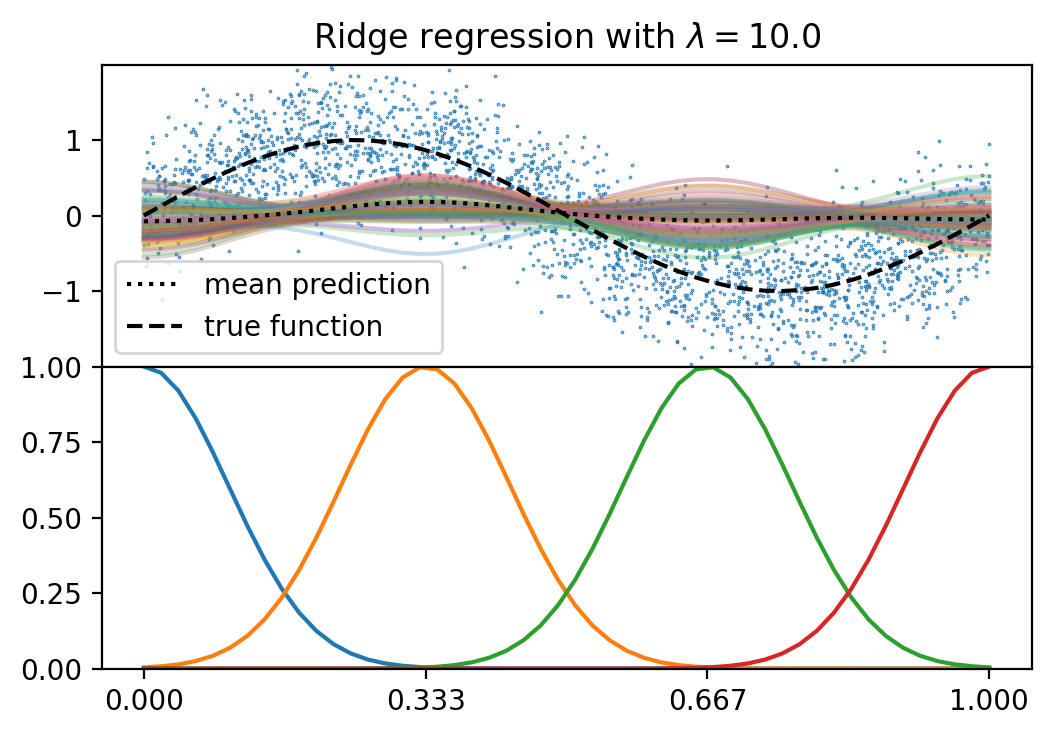

In [ ]:
domain = jnp.linspace(0,1,50)
ypred = jax.vmap(phi)(domain) @ all_thetas.T

fig, axes = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

axes[0].plot(domain, ypred, alpha=0.25);
axes[0].plot(domain, jnp.mean(ypred, axis=1), c='k', ls=':', label='mean prediction');
axes[0].plot(domain, f(domain), c='k', ls='--', label='true function');

axes[0].set_yticks([-1, 0, 1])
axes[0].set_ylim(-2, 2)
axes[0].scatter(X, Y, s=1e-1)
axes[0].set_title(f"Ridge regression with $\lambda={ridge_coeff}$")
axes[0].legend()

axes[1].plot(domain, jax.vmap(phi)(domain))
axes[1].set_yticks(jnp.linspace(0, 1, 5))
axes[1].set_xticks(locations)
axes[1].set_ylim(0, 1);

## Question 1.1

What happens when you increase the number of basis functions? Add code to run experiment and produce plot. 

X:(25,), A:(25, 10)
U: (25, 25), D: (25, 10), V: (10, 10)


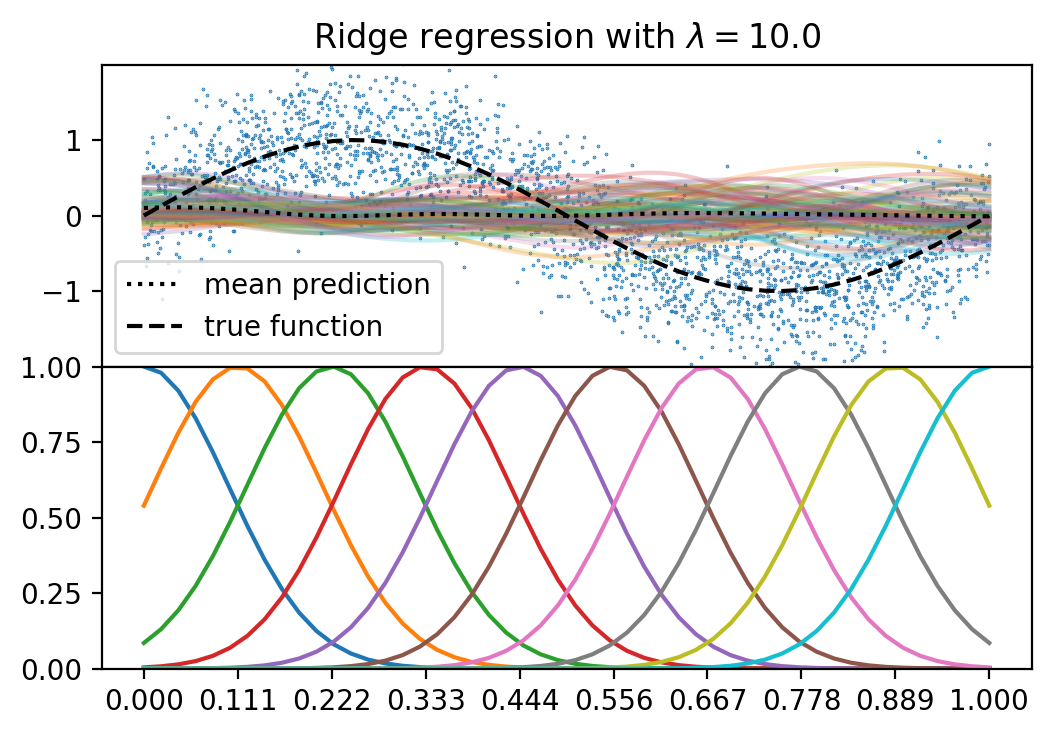

In [ ]:
n_basis = 10
scales = jnp.ones(shape=(n_basis,))*scale
locations = jnp.linspace(0,1,n_basis)
phi = gaussian_basis_function(locations, scales)

all_thetas = jax.vmap(ridge_regression, in_axes=(0,0,None,None))(X, Y, phi, ridge_coeff)

domain = jnp.linspace(0,1,50)
ypred = jax.vmap(phi)(domain) @ all_thetas.T

fig, axes = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

axes[0].plot(domain, ypred, alpha=0.25);
axes[0].plot(domain, jnp.mean(ypred, axis=1), c='k', ls=':', label='mean prediction');
axes[0].plot(domain, f(domain), c='k', ls='--', label='true function');

axes[0].set_yticks([-1, 0, 1])
axes[0].set_ylim(-2, 2)
axes[0].scatter(X, Y, s=1e-1)
axes[0].set_title(f"Ridge regression with $\lambda={ridge_coeff}$")
axes[0].legend()

axes[1].plot(domain, jax.vmap(phi)(domain))
axes[1].set_yticks(jnp.linspace(0, 1, 5))
axes[1].set_xticks(locations)
axes[1].set_ylim(0, 1);

n_basis=4

# From the previous plot, we see that the variance is concentrated around the peak of each gaussian function. 
# Adding more gaussian functions allows for more variance in general and allows for more expressivity.
# The solutions obtained vary widely from the average solution.

Your explanation here

## Question 1.2

What happens as you decrease the scale parameter? Add code to run experiment and produce plot

X:(25,), A:(25, 4)
U: (25, 25), D: (25, 4), V: (4, 4)


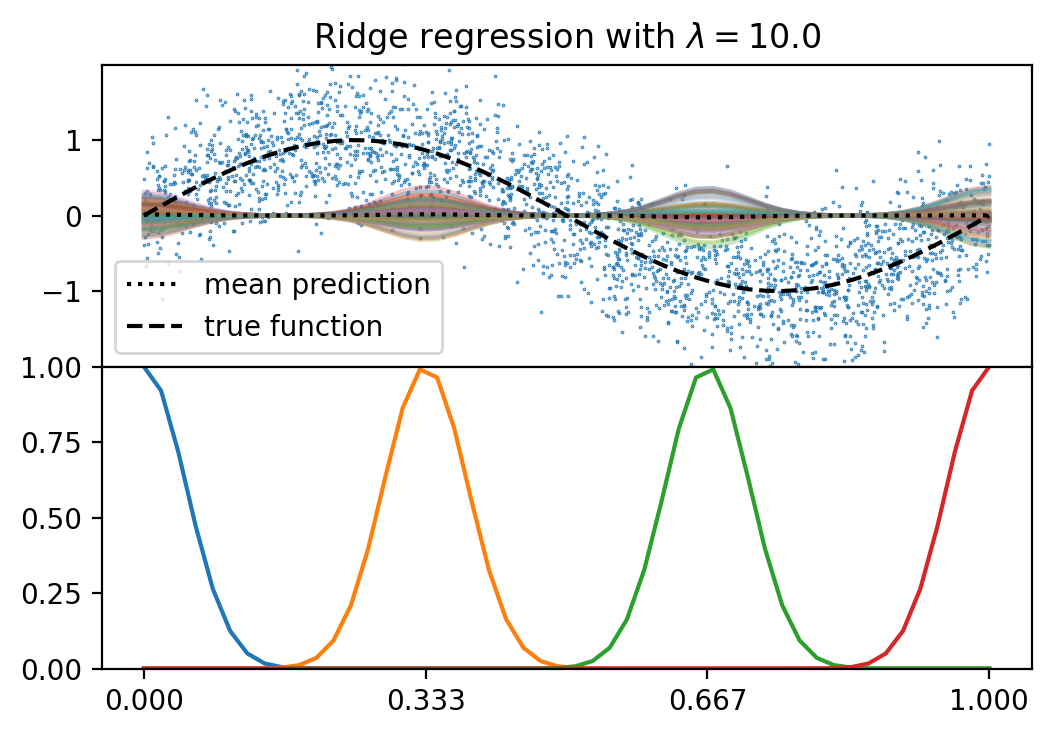

In [ ]:
scale=0.05
scales = jnp.ones(shape=(n_basis,))*scale
locations = jnp.linspace(0,1,n_basis)

phi = gaussian_basis_function(locations, scales)

all_thetas = jax.vmap(ridge_regression, in_axes=(0,0,None,None))(X, Y, phi, ridge_coeff)

domain = jnp.linspace(0,1,50)
ypred = jax.vmap(phi)(domain) @ all_thetas.T

fig, axes = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

axes[0].plot(domain, ypred, alpha=0.25);
axes[0].plot(domain, jnp.mean(ypred, axis=1), c='k', ls=':', label='mean prediction');
axes[0].plot(domain, f(domain), c='k', ls='--', label='true function');

axes[0].set_yticks([-1, 0, 1])
axes[0].set_ylim(-2, 2)
axes[0].scatter(X, Y, s=1e-1)
axes[0].set_title(f"Ridge regression with $\lambda={ridge_coeff}$")
axes[0].legend()

axes[1].plot(domain, jax.vmap(phi)(domain))
axes[1].set_yticks(jnp.linspace(0, 1, 5))
axes[1].set_xticks(locations)
axes[1].set_ylim(0, 1);

scale=0.1

# Reducing the scale parameter narrows the gaussian functions and concentrates the variance even more aggressively around their peaks.
# Most solutions found are very close to the average solution.

Your explanation here

## Question 1.3

What happens as you increase the ridge penalty coefficient? Add code to run experiment and produce plot

X:(25,), A:(25, 4)
U: (25, 25), D: (25, 4), V: (4, 4)


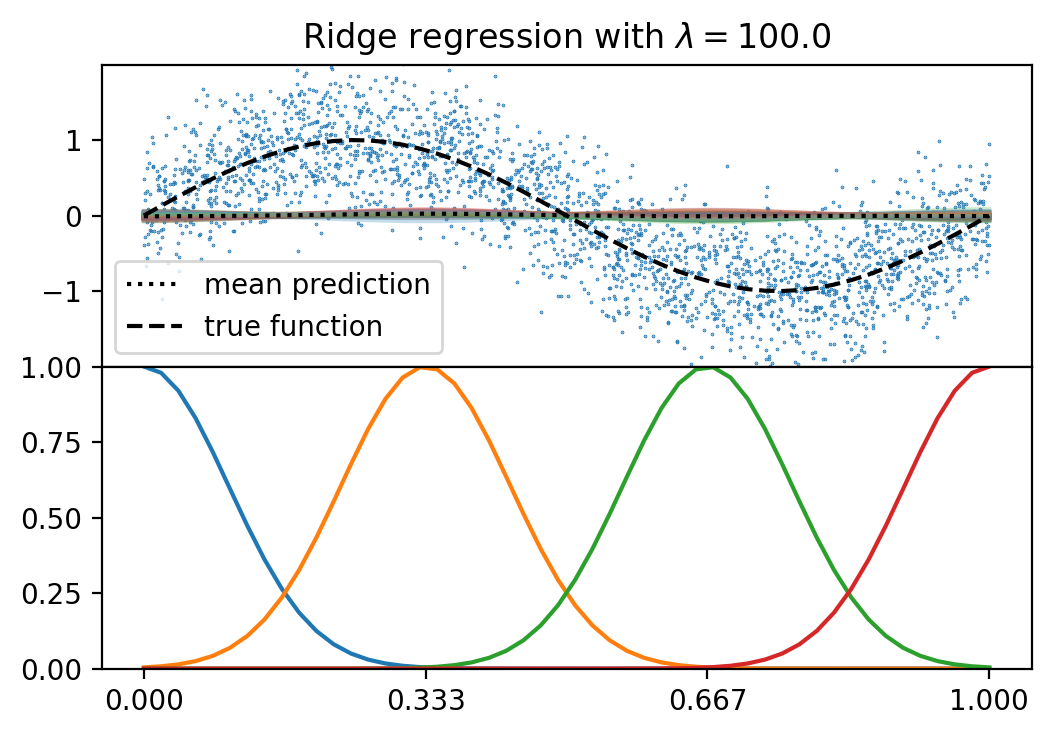

In [ ]:
ridge_coeff = 1e2
scales = jnp.ones(shape=(n_basis,))*scale
locations = jnp.linspace(0,1,n_basis)

phi = gaussian_basis_function(locations, scales)

all_thetas = jax.vmap(ridge_regression, in_axes=(0,0,None,None))(X, Y, phi, ridge_coeff)

domain = jnp.linspace(0,1,50)
ypred = jax.vmap(phi)(domain) @ all_thetas.T

fig, axes = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

axes[0].plot(domain, ypred, alpha=0.25);
axes[0].plot(domain, jnp.mean(ypred, axis=1), c='k', ls=':', label='mean prediction');
axes[0].plot(domain, f(domain), c='k', ls='--', label='true function');

axes[0].set_yticks([-1, 0, 1])
axes[0].set_ylim(-2, 2)
axes[0].scatter(X, Y, s=1e-1)
axes[0].set_title(f"Ridge regression with $\lambda={ridge_coeff}$")
axes[0].legend()

axes[1].plot(domain, jax.vmap(phi)(domain))
axes[1].set_yticks(jnp.linspace(0, 1, 5))
axes[1].set_xticks(locations)
axes[1].set_ylim(0, 1);

ridge_coeff = 1e1

# Increasing the ridge penalty coefficient means a more selective prior on weights during training in order to safeguard against overfitting.
# By limiting capacity, we observe a lower variance at the sacrifice of a higher bias. 
# This translates in a tighter enveloppe around the average solution, while the average solution itself flattens out and moves away from the true function.

Your explanation here

# Part 2: Bias-Variance Tradeoff

With all of these ridge regression solutions computed in the previous part, we can now get a sense of how the bias and variance terms vary for different degree of regularization. Let $m$ be the number of datasets, and $n$ the number of instances per dataset. We define the mean predictor $\bar{f}$ as:
\begin{align*}
\bar{f}(x) \triangleq \frac{1}{m} \sum_{i=1}^m \hat{f}(x; \theta_i)\enspace .
\end{align*}
The squared bias is: 
\begin{align*}
\text{bias}^2 = \frac{1}{n} \sum_{j=1}^n (\bar{f}(x_j) - f(x_j))^2 \enspace ,
\end{align*}
and the variance: 
\begin{align*}
\text{variance} = \frac{1}{n} \sum_{j=1}^n \frac{1}{m} \sum_{i=1}^m (\hat{f}(x_j; \theta_i) - \bar{f}(x_j))^2 \enspace .
\end{align*}

In [ ]:
def bias_variance_estimate(ridge_coeff, X, Y, phi, n_test=1000, n_points=50, input_range=(0., 1.)):
  
  # Ridge regressiong solution
  all_thetas = jax.vmap(ridge_regression, in_axes=(0,0,None,None))(X, Y, phi, ridge_coeff)
  domain = jnp.linspace(*input_range,n_points)  
  ypred = jax.vmap(phi)(domain) @ all_thetas.T

  # print(jax.vmap(phi)(domain).shape)
  # print(all_thetas.shape)
  # print(ypred.shape)

  # YOUR CODE HERE
  #MEAN
  mean_predictor = jnp.mean(ypred)

  # BIAS
  bias_squared = 0
  # bias_squared = jnp.mean((mean_predictor-Y)**2)

  # VAR
  variance = 0
  for i in range(len(all_thetas)):
    for j in range (len(X)):
      variance += (ypred[j, i] - mean_predictor)**2
  variance = variance/(len(all_thetas)*len(X))

  # # Predicted labels over test domain
  test_domain = jnp.linspace(*input_range, n_test)
  ypred = jax.vmap(phi)(test_domain) @ all_thetas.T

  # TEST (least squares)
  test_error=0
  ytest = f(test_domain)
  print(ypred.shape)
  print(ytest.shape)
  # test_error = jnp.sum((ypred-ytest)**2)/jnp.size(ypred)

  return bias_squared, variance, bias_squared + variance, test_error

We then compute this decomposition for a range of values for the regularization coefficient $\lambda$ chosen uniformly on the grid in log (base 10) space. You should keep the following plotting code intact.

X:(25,), A:(25, 4)
U: (25, 25), D: (25, 4), V: (4, 4)
(1000, 100)
(1000,)


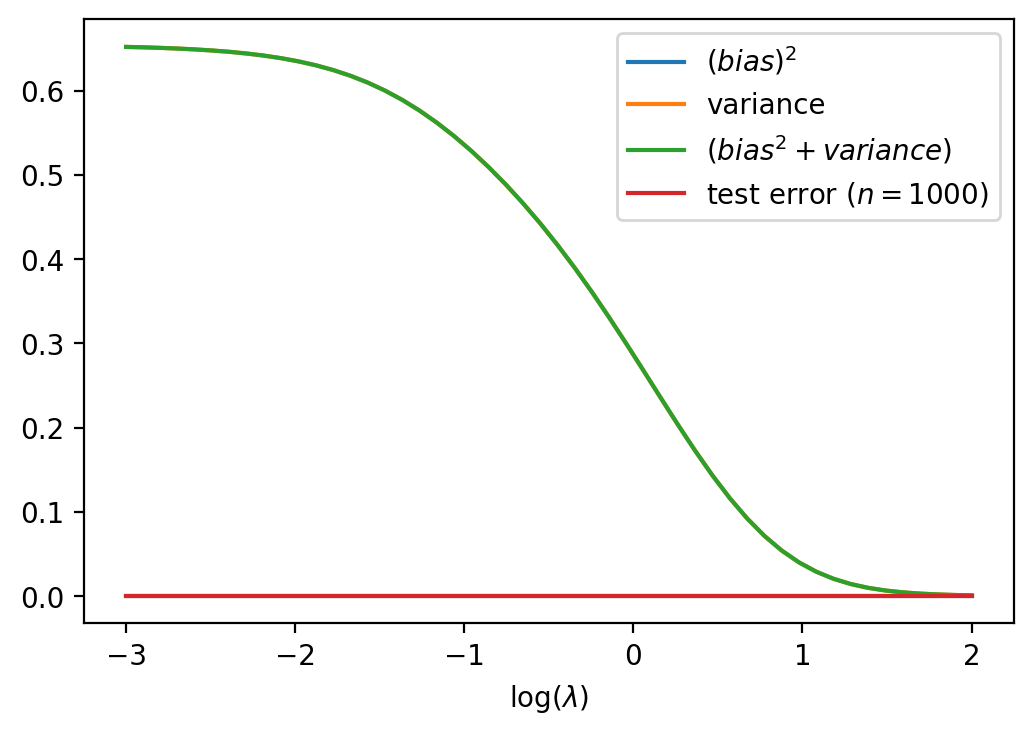

In [ ]:
n_test = 1000

ridge_coeffs = jnp.logspace(-3, 2)
biases, variances, sum_bias_variance, test_errors = jax.vmap(bias_variance_estimate, in_axes=(0, None, None, None, None))(ridge_coeffs, X, Y, phi, n_test)


plt.plot(jnp.log10(ridge_coeffs), biases, label='$(bias)^2$')
plt.plot(jnp.log10(ridge_coeffs), variances, label='variance')
plt.plot(jnp.log10(ridge_coeffs), sum_bias_variance, label='$(bias^2 + variance)$')
plt.plot(jnp.log10(ridge_coeffs), test_errors, label=f"test error ($n = {n_test})$")
plt.xlabel('$\log(\lambda)$')
plt.legend();

## Question 2.1

Explain what happens to the bias-variance tradeoff as a function of the ridge regression coefficient. Complete code to run experiment and produce plot. **Explain results in words, say something about each lines in the plot.** Identify the *sweetspot* for generalization.

In [ ]:
# Since I have not succesfully vectorized the bias and test error the previous exercise, I will reference the graph provided in the template to answer this exercise.

# As mentionned previously, regularization helps prevent overfitting by limit a models capacity. 
# An increase in the ridge coefficient corresponds to lower capacity: this translates into lower variance but higher bias.

# When inspecting the plot, we see that the variance is monotonic and decreasing. This makes sense since a higher coefficient means more selective priors on model weights during training. The total pool of considered models therefore keeps going down.
# The bias seems to be monotonic and increasing. Again, this makes senses because of the shrinking size of the set of considered models. We keep getting ''further and further away'' from the true solution.
# An interesting observation is that both variance and bias seem to be flat for a little while, which would indicate that the model had so much capacity that small penalties to its parameters' norm still left it with ''plenty to do the job''.
# Finally, we see that the test error and the (bias_squared+variance) curves follow each other closely. This is because the only unaccounted factor between them is the irreducible error.

# The optimal ridge regression coefficient is the one where the test error (bias_squared + variance + irreducible error) is lowest.

Your explanation here

# Part 3: Kernel Ridge Regression

We saw in class on Monday (February 14) that infinite-dimensional optimization problems of the form: 
\begin{align*}
\min_{f \in \mathcal{H}_K} \sum_{i=1}^N L(f(x_i), y_i)) + \lambda \|f\|^2_{\mathcal{H}_K} \enspace, 
\end{align*}
can be written as a finite-dimensional counterpart: 
\begin{align*}
\min_{\alpha \in \mathbb{R}^{|\mathcal{D}|}} L(K\alpha, y) + \lambda \alpha^\top K \alpha \enspace .
\end{align*}

Given any two vectors $x$ and $y$, the squared-error loss can be written as: 
\begin{align*}
L(x,y) \triangleq (x - y)^\top (x - y) \enspace .
\end{align*}


## Question 3.1

Re-write the finite-dimensional optimization problem corresponding to the squared-loss. Write your answer in matrix form 



\begin{align*}
  \min_{\alpha} (X\alpha-Y)^{\prime}(X\alpha-Y) + \lambda \alpha^{\prime}K\alpha &=\\
  \min_{\alpha} (X\alpha-Y)^{\prime}(X\alpha-Y) + \lambda \alpha^{\prime}X^{*}X\alpha &=\\
    \min_{\alpha} ||K\alpha-Y||^2 + \lambda \alpha^{\prime}K\alpha &=\\
\end{align*}


## Question 3.2

Using the answer above, give the expression for the gradient of the kernelized loss with respect to $\alpha$. Set the gradient to zero and solve for the optimal value of the coefficient vector $\alpha$.

\begin{align*}
  \frac{\partial }{\partial \alpha} \left[ ||K\alpha-Y||^2 + \lambda \alpha^{\prime}K\alpha \right] &= 0 \implies\\
  -K y+ K^2 y \alpha+\lambda K \alpha &= 0 \implies \\
  (K+\lambda I)^{-1}y &= \alpha
\end{align*}

## Question 3.3

Implement the kernel ridge regression solution. **Do not use explicit matrix inversion**.

In [ ]:
def fit_predict(xtrain, ytrain, xtest, ridge_coeff=1.):
  """
  xtrain (ndarray): (n_samples,)
  ytrain (ndarray): (n_samples,)
  xtest (ndarray): (n_samples_test,)
  ridge_coeff (float): regularization coefficient
  """

  # alpha
  alpha =  (jnp.matmul(xtrain, xtrain)+ ridge_coeff * jnp.identity(X.shape[1]))

  # Pseudo inverse
  alpha = 1/alpha
  alpha = alpha.T
  alpha = jnp.matmul(alpha, ytrain)

  # Test preds
  ypred = jnp.matmul(jax.vmap(phi)(xtest), alpha)

  return ypred

Rather than predicting for all datasets simultaneously (although we could), we just pick the first dataset for this exercise:

In [ ]:
xtrain = X[0,:]
ytrain = Y[0,:]

Use `vmap` to then obtain the Gram matrix: 

In [ ]:
scale = 0.1
phi = gaussian_basis_function(xtrain, scale)
K = jax.vmap(phi)(X)

We can finally `vmap` over all of the regularization coefficients (from a grid in log space) to obtain all the corresponding solutions (but for the same dataset) simultaneously:

In [ ]:
regularizations = jnp.logspace(-1,1,5)
ypred = jax.vmap(fit_predict, in_axes=(None, None, None, 0))(xtrain, ytrain, domain, regularizations)

In our plot, we visualize the predicted values of all models, which we overlay on top of the true function. 

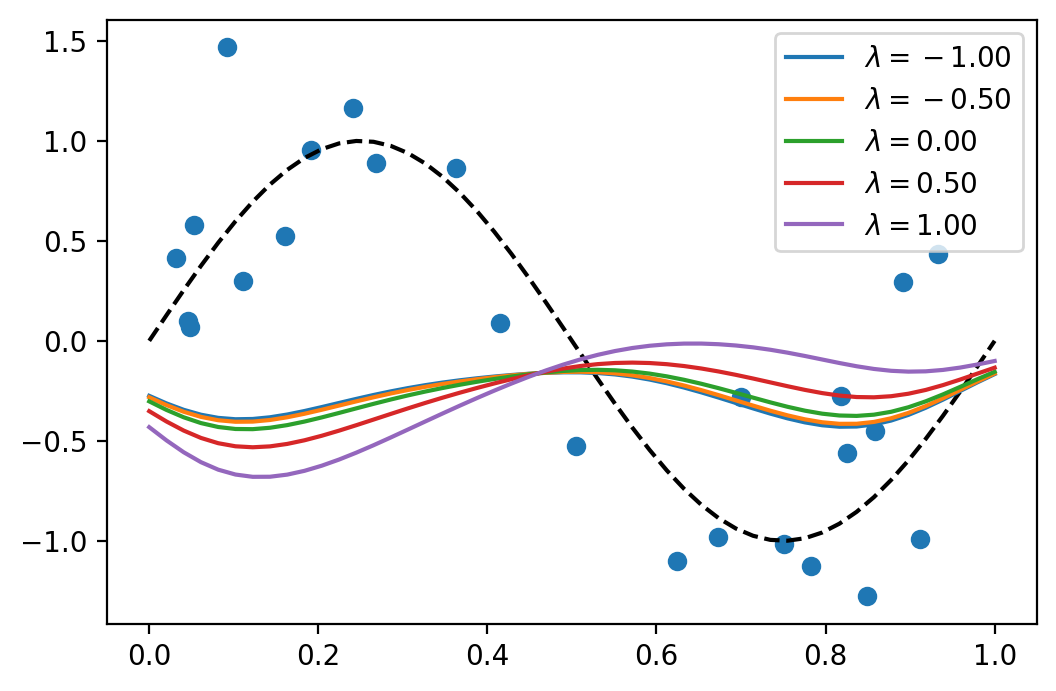

In [ ]:
plt.plot(domain, f(domain), c='k', ls='--', label='True function')
plt.scatter(X[0,:], Y[0,:])
lines = plt.plot(domain, ypred.T);
labels = map(lambda c: f"$\lambda = {c:.2f}$", jnp.log10(regularizations))
plt.legend(lines, labels)

## Question 3.3

Using the code above, explain in words and with a plot how the ridge coefficient affects the solution of the kernelized ridge regression. 



In [ ]:
# We see that curves with lower coefficients have more variation and expressivity, while curves with higher coefficient tend to flatten out. 
# We can understand this behavior by considering the effect of regularization on capacity. Higher coefficients impose stricter priors
# on weights and favor models with small weight norms. Smaller norms can be interpreted as reducing sensitivity to inputs or as 
# reducing the model's expressivity. For example, by limiting the size of the coefficient in a polynomial, said  polynomial will
# no longer be able to model every other in its class. 



Your explanation here

## Question 3.4

Kernel ridge regression with a Gaussian RBF kernel vs ridge regression with an explicit nonlinear expansian in a Gaussian RBF basis. Are these two methods equivalent? Answer in words and math. Add code and plot to support your answer.

In [ ]:
# Your code here

Your explanation here